In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv("../.env")

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

embedding = HuggingFaceEmbeddings(
            model_name="../../../../Embedding/maidalun/bce-embedding-base_v1",
            model_kwargs={"device": "cuda",
                          "trust_remote_code": True},
            encode_kwargs={"normalize_embeddings": True},
        )

c:\Users\farben\anaconda3\envs\lclg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set up Graph

In [2]:
import random
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


class MyNode:
    def __init__(self, name: str):
        self.name = name

    def __call__(self, state: State):
        return {"messages": [("assistant", f"Called node {self.name}")]}


def route(state) -> Literal["entry_node", "__end__"]:
    if len(state["messages"]) > 10:
        return "__end__"
    return "entry_node"


def add_fractal_nodes(builder, current_node, level, max_level):
    if level > max_level:
        return

    # Number of nodes to create at this level
    num_nodes = random.randint(1, 3)  # Adjust randomness as needed
    for i in range(num_nodes):
        nm = ["A", "B", "C"][i]
        node_name = f"node_{current_node}_{nm}"
        builder.add_node(node_name, MyNode(node_name))
        builder.add_edge(current_node, node_name)

        # Recursively add more nodes
        r = random.random()
        if r > 0.2 and level + 1 < max_level:
            add_fractal_nodes(builder, node_name, level + 1, max_level)
        elif r > 0.05:
            builder.add_conditional_edges(node_name, route, node_name)
        else:
            # End
            builder.add_edge(node_name, "__end__")


def build_fractal_graph(max_level: int):
    builder = StateGraph(State)
    entry_point = "entry_node"
    builder.add_node(entry_point, MyNode(entry_point))
    builder.add_edge(START, entry_point)

    add_fractal_nodes(builder, entry_point, 1, max_level)

    # Optional: set a finish point if required
    builder.add_edge(entry_point, END)  # or any specific node

    return builder.compile()


app = build_fractal_graph(3)

# Mermaid

In [3]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	entry_node(entry_node)
	node_entry_node_A(node_entry_node_A)
	node_entry_node_B(node_entry_node_B)
	node_node_entry_node_B_A(node_node_entry_node_B_A)
	node_node_entry_node_B_B(node_node_entry_node_B_B)
	node_node_entry_node_B_C(node_node_entry_node_B_C)
	__end__([<p>__end__</p>]):::last
	__start__ --> entry_node;
	entry_node --> __end__;
	entry_node --> node_entry_node_A;
	entry_node --> node_entry_node_B;
	node_entry_node_B --> node_node_entry_node_B_A;
	node_entry_node_B --> node_node_entry_node_B_B;
	node_entry_node_B --> node_node_entry_node_B_C;
	node_entry_node_A -.-> entry_node;
	node_entry_node_A -.-> __end__;
	node_node_entry_node_B_A -.-> entry_node;
	node_node_entry_node_B_A -.-> __end__;
	node_node_entry_node_B_B -.-> entry_node;
	node_node_entry_node_B_B -.-> __end__;
	node_node_entry_node_B_C -.-> entry_node;
	node_node_entry_node_B_C -.-> __end__;
	classDef default fill:#f2f

# PNG

## Using Mermaid.Ink

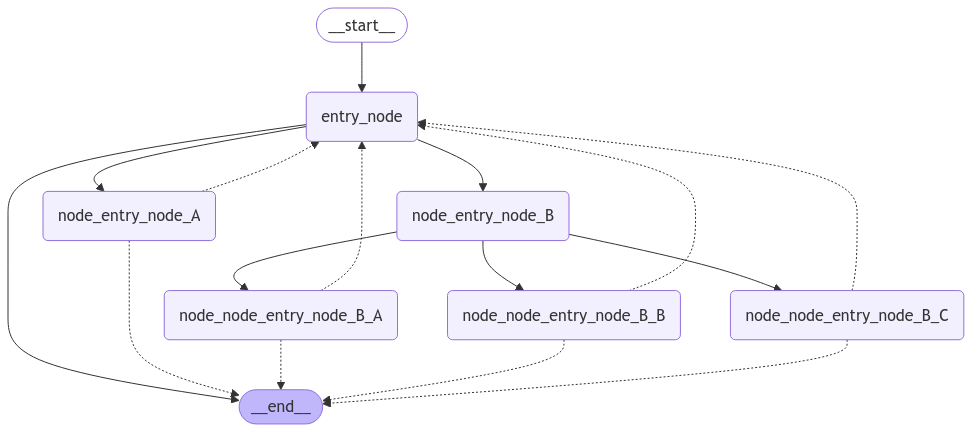

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)